<a href="https://colab.research.google.com/github/MHX1203/DataWhale--/blob/master/DigitsRecognization-02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 增加内容

## 数据增强

- Random Noise Augmentation

## 模型
- resnet18

## 损失函数
- LabelSmooth


## 模型集成
- TODO

# 载入数据

In [1]:
# 连接google drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# 解压数据

!mkdir data
!unzip drive/My\ Drive/Data/Datawhale-DigitsRecognition/mchar_test_a.zip -d data/ > /dev/null 2>&1
!unzip drive/My\ Drive/Data/Datawhale-DigitsRecognition/mchar_train.zip -d data/ > /dev/null 2>&1
!unzip drive/My\ Drive/Data/Datawhale-DigitsRecognition/mchar_val.zip -d data/ > /dev/null 2>&1


In [0]:
data_dir = {
    'train_data': '/content/data/mchar_train/',
    'val_data': '/content/data/mchar_val/',
    'test_data': '/content/data/mchar_test_a/',
    'train_label': '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/mchar_train.json',
    'val_label': '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/mchar_val.json',
    'submit_file': '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/mchar_sample_submit_A.csv'
}

# 导入相关库

In [0]:
import os
from glob import glob
import torch as t
t.random.manual_seed(0)
t.cuda.manual_seed_all(0)
t.backends.cudnn.benchmark = True
t.backends.cudnn.deterministic = True
from PIL import Image
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, MultiStepLR, CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch 
import torch.nn.functional as F
import json
from torchvision.models.mobilenet import MobileNetV2
from torchvision.models.resnet import resnet18, resnet34
from torchsummary import summary
%matplotlib inline

# 查看数据

In [5]:
def data_summary():
  train_list = glob(data_dir['train_data']+'*.png')
  test_list = glob(data_dir['test_data']+'*.png')
  val_list = glob(data_dir['val_data']+'*.png')
  print('train image counts: %d'%len(train_list))
  print('val image counts: %d'%len(val_list))
  print('test image counts: %d'%len(test_list))

data_summary()

train image counts: 30000
val image counts: 10000
test image counts: 40000


In [6]:
def look_train_json():
  with open(data_dir['train_label'], 'r', encoding='utf-8') as f:
    content = f.read()

  content = json.loads(content)

  print(content['000000.png'])

look_train_json()

{'height': [219, 219], 'label': [1, 9], 'left': [246, 323], 'top': [77, 81], 'width': [81, 96]}


In [7]:
def look_submit():
  df = pd.read_csv(data_dir['submit_file'], sep=',')
  print(df.head(5))

look_submit()

    file_name  file_code
0  000000.png          0
1  000001.png          0
2  000002.png          0
3  000003.png          0
4  000004.png          0


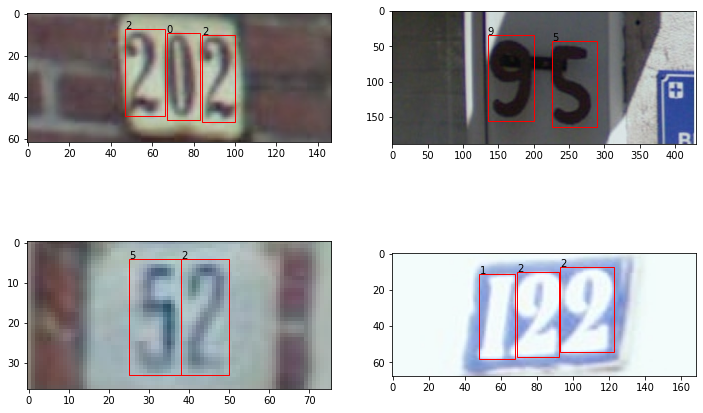

In [8]:
def plot_samples():
  imgs = glob(data_dir['train_data']+'*.png')
  fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)
  marks = json.loads(open(data_dir['train_label'], 'r').read())


  for i in range(4):
    
    img_name = os.path.split(imgs[i])[-1]
    mark = marks[img_name]


    img = Image.open(imgs[i])
    img = np.array(img)

    bboxes = np.array(
        [mark['left'],
        mark['top'],
        mark['width'],
        mark['height']]
    )
    ax[i//2, i%2].imshow(img)
    for j in range(len(mark['label'])):
      rect = patch.Rectangle(bboxes[:, j][:2], bboxes[:, j][2], bboxes[:, j][3], facecolor='none', edgecolor='r')
      ax[i//2, i%2].text(bboxes[:, j][0], bboxes[:, j][1], mark['label'][j])
      ax[i//2, i%2].add_patch(rect)
  plt.show()

plot_samples()

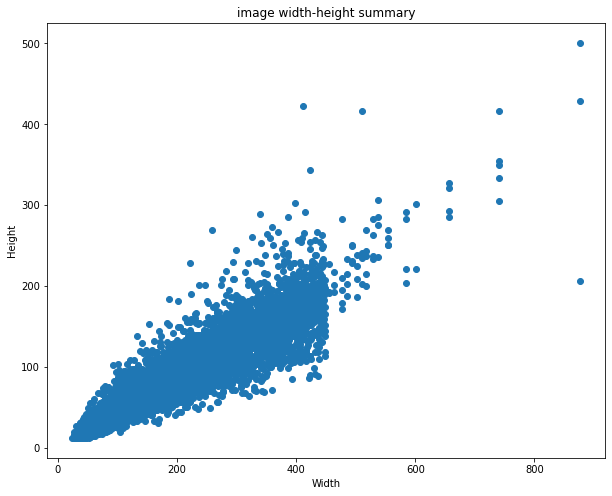

In [9]:
def img_size_summary():
  sizes = []

  for img in glob(data_dir['train_data']+'*.png'):
    img = Image.open(img)

    sizes.append(img.size)

  sizes = np.array(sizes)

  plt.figure(figsize=(10, 8))
  plt.scatter(sizes[:, 0], sizes[:, 1])
  plt.xlabel('Width')
  plt.ylabel('Height')

  plt.title('image width-height summary')
  plt.show()

img_size_summary()


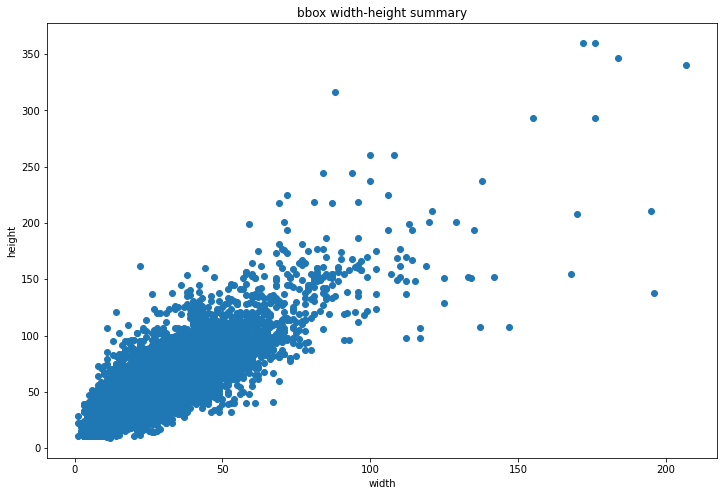

In [10]:
def bbox_summary():
  marks = json.loads(open(data_dir['train_label'], 'r').read())
  bboxes = []

  for img, mark in marks.items():
    for i in range(len(mark['label'])):
      bboxes.append([mark['left'][i], mark['top'][i], mark['width'][i], mark['height'][i]])

  bboxes = np.array(bboxes)

  fig, ax = plt.subplots(figsize=(12, 8))
  ax.scatter(bboxes[:, 2], bboxes[:, 3])
  ax.set_title('bbox width-height summary')
  ax.set_xlabel('width')
  ax.set_ylabel('height')
  plt.show()

bbox_summary()

In [11]:
def label_summary():
  marks = json.load(open(data_dir['train_label'], 'r'))
  
  dicts = {}
  for img, mark in marks.items():
    if len(mark['label']) not in dicts:
      dicts[len(mark['label'])] = 0
    dicts[len(mark['label'])] += 1


  dicts = sorted(dicts.items(), key=lambda x: x[0])
  for k, v in dicts:
    print('%d个数字的图片数目: %d'%(k, v))

label_summary()

1个数字的图片数目: 4636
2个数字的图片数目: 16262
3个数字的图片数目: 7813
4个数字的图片数目: 1280
5个数字的图片数目: 8
6个数字的图片数目: 1


# 构建分类Baseline

## 网络配置信息

In [0]:
class Config:

  batch_size = 16

  lr = 1e-2

  momentum = 0.9

  weights_decay = 1e-5

  class_num = 11

  eval_interval = 1

  checkpoint_interval = 1

  print_interval = 50

  checkpoints = 'drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/'

  pretrained = '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/epoch-30_acc-61.57.pth'

  start_epoch = 0

  epoches = 50

  smooth = 0.1

  erase_prob = 0.5

config = Config()



## 构建数据集

In [0]:

class DigitsDataset(Dataset):
  """
  
  DigitsDataset

  Params:
    data_dir(string): data directory

    label_path(string): label path

    aug(bool): wheather do image augmentation, default: True
  """
  def __init__(self, data_dir, label_path, size=(128, 256), aug=True):
    super(DigitsDataset, self).__init__()
    self.imgs = glob(data_dir+'*.png')

    self.aug = aug

    self.size = size
    if label_path == None:
      self.labels = None
    else:
      self.labels = json.load(open(label_path, 'r'))
      self.imgs = [(img, self.labels[os.path.split(img)[-1]]) for img in self.imgs if os.path.split(img)[-1] in self.labels]
    
  def __getitem__(self, idx):
    if self.labels:
      img, label = self.imgs[idx]
    else:
      img = self.imgs[idx]
      label = None

    img = Image.open(img)

    trans0 = [                
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
    
    min_size = self.size[0] if (img.size[1] / self.size[0]) < ((img.size[0] / self.size[1])) else self.size[1]
    trans1 = [
          transforms.Resize(min_size),    
          transforms.CenterCrop(self.size)
        ]

    if self.aug:
      trans1.extend([
            transforms.ColorJitter(0.1, 0.1, 0.1),
            transforms.RandomGrayscale(0.1),
            transforms.RandomAffine(10,translate=(0.05, 0.1), shear=5)
      ])

    trans1.extend(trans0)
    
    img = transforms.Compose(trans1)(img)

    if self.labels:
      return img, t.tensor(label['label'][:5] + (5 - len(label['label']))*[10]).long()
    else:
      return img, self.imgs[idx]


  def __len__(self):
    return len(self.imgs)



In [14]:
# test dataset
dataset = DigitsDataset(data_dir['train_data'], data_dir['train_label'])
print(len(dataset))
img, label = dataset[0]

print(img.shape, label.shape)

30000
torch.Size([3, 128, 256]) torch.Size([5])


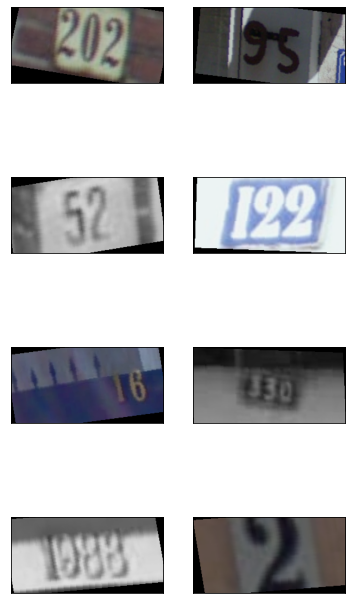

In [15]:
fig, ax = plt.subplots(figsize=(6, 12), nrows=4, ncols=2)
for i in range(8):
  img, label = dataset[i]
  img = img * t.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + t.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
  ax[i//2, i%2].imshow(img.permute(1, 2, 0).numpy())

  ax[i//2, i%2].set_xticks([])
  ax[i//2, i%2].set_yticks([])

plt.show()


## 构建分类模型

In [0]:
class DigitsMobilenet(nn.Module):

  def __init__(self, class_num=11):
    super(DigitsMobilenet, self).__init__()

    self.net = nn.Sequential(
        MobileNetV2(num_classes=class_num).features,
        nn.AdaptiveAvgPool2d((1, 1))
    )
    self.fc1 = nn.Linear(1280, class_num)
    self.fc2 = nn.Linear(1280, class_num)
    self.fc3 = nn.Linear(1280, class_num)
    self.fc4 = nn.Linear(1280, class_num)
    self.fc5 = nn.Linear(1280, class_num)

  def forward(self, img):
    features = self.net(img).view(-1, 1280)

    fc1 = self.fc1(features)
    fc2 = self.fc2(features)
    fc3 = self.fc3(features)
    fc4 = self.fc4(features)
    fc5 = self.fc5(features)

    return fc1, fc2, fc3, fc4, fc5


class DigitsResnet18(nn.Module):

  def __init__(self, class_num=11):
    super(DigitsMobilenet, self).__init__()
    self.net = resnet18(pretrained=True)
    self.net.fc = nn.Identity()
    # self.net = nn.Sequential(
    #     MobileNetV2(num_classes=class_num).features,
    #     nn.AdaptiveAvgPool2d((1, 1))
    # )
    self.fc1 = nn.Linear(512, class_num)
    self.fc2 = nn.Linear(512, class_num)
    self.fc3 = nn.Linear(512, class_num)
    self.fc4 = nn.Linear(512, class_num)
    self.fc5 = nn.Linear(512, class_num)

  def forward(self, img):
    features = self.net(img).squeeze()

    fc1 = self.fc1(features)
    fc2 = self.fc2(features)
    fc3 = self.fc3(features)
    fc4 = self.fc4(features)
    fc5 = self.fc5(features)

    return fc1, fc2, fc3, fc4, fc5

In [22]:
# 查看网络结构
net = resnet18(pretrained=True)
net.to(t.device('cuda'))
summary(net, input_size=(3, 128, 256), batch_size=config.batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [16, 64, 64, 128]           9,408
       BatchNorm2d-2          [16, 64, 64, 128]             128
              ReLU-3          [16, 64, 64, 128]               0
         MaxPool2d-4           [16, 64, 32, 64]               0
            Conv2d-5           [16, 64, 32, 64]          36,864
       BatchNorm2d-6           [16, 64, 32, 64]             128
              ReLU-7           [16, 64, 32, 64]               0
            Conv2d-8           [16, 64, 32, 64]          36,864
       BatchNorm2d-9           [16, 64, 32, 64]             128
             ReLU-10           [16, 64, 32, 64]               0
       BasicBlock-11           [16, 64, 32, 64]               0
           Conv2d-12           [16, 64, 32, 64]          36,864
      BatchNorm2d-13           [16, 64, 32, 64]             128
             ReLU-14           [16, 64,

In [17]:
net = DigitsMobilenet()
print(net)

DigitsMobilenet(
  (net): Sequential(
    (0): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [18]:
# 查看网络结构
net.to(t.device('cuda'))
summary(net, input_size=(3, 128, 256), batch_size=config.batch_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [16, 32, 64, 128]             864
       BatchNorm2d-2          [16, 32, 64, 128]              64
             ReLU6-3          [16, 32, 64, 128]               0
            Conv2d-4          [16, 32, 64, 128]             288
       BatchNorm2d-5          [16, 32, 64, 128]              64
             ReLU6-6          [16, 32, 64, 128]               0
            Conv2d-7          [16, 16, 64, 128]             512
       BatchNorm2d-8          [16, 16, 64, 128]              32
  InvertedResidual-9          [16, 16, 64, 128]               0
           Conv2d-10          [16, 96, 64, 128]           1,536
      BatchNorm2d-11          [16, 96, 64, 128]             192
            ReLU6-12          [16, 96, 64, 128]               0
           Conv2d-13           [16, 96, 32, 64]             864
      BatchNorm2d-14           [16, 96,

## 训练模型

In [0]:
# ----------------------------------- LabelSmoothEntropy ----------------------------------- #
class LabelSmoothEntropy(nn.Module):
  def __init__(self, smooth=0.1, class_weights=None, size_average='mean'):
    super(LabelSmoothEntropy, self).__init__()
    self.size_average = size_average
    self.smooth = smooth

    self.class_weights = class_weights
    

  def forward(self, preds, targets):

    lb_pos, lb_neg = 1 - self.smooth, self.smooth / (preds.shape[0] - 1)

    smoothed_lb = t.zeros_like(preds).fill_(lb_neg).scatter_(1, targets[:, None], lb_pos)

    log_soft = F.log_softmax(preds)

    if self.class_weights is not None:
      loss = -log_soft * smoothed_lb * self.class_weights[None, :]

    else:
      loss = -log_soft * smoothed_lb

    loss = loss.sum(1)
    if self.size_average == 'mean':
      return loss.mean()

    elif self.size_average == 'sum':
      return loss.sum()
    else:
      raise NotImplementedError

  

In [0]:
# ----------------------------------- SnapShot ----------------------------------- #
class SnapShotBuilder():

  """
  
  Params:
    n_epoch(integer): total training epoches

    n_snap(integer): parameters of model saved times

  """
  def __init__(self, n_epoch, n_snap):

    self.n_epoch = n_epoch

    self.n_snap = n_snap

    pass

  def __call__(self):

    pass

  def _scheduler(self):

    pass

In [0]:
class Trainer:

  def __init__(self):

    self.device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')

    self.train_loader = DataLoader(DigitsDataset(data_dir['train_data'], data_dir['train_label']), batch_size=config.batch_size, \
                    num_workers=8, pin_memory=True, drop_last=True)
    

    self.val_loader = DataLoader(DigitsDataset(data_dir['val_data'], data_dir['val_label'], aug=False), batch_size=config.batch_size,\
                    num_workers=8, pin_memory=True, drop_last=True)



    self.model = DigitsMobilenet(config.class_num).to(self.device)


    self.criterion = LabelSmoothEntropy().to(self.device)

    self.optimizer = SGD(self.model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weights_decay, nesterov=True)

    self.lr_scheduler = CosineAnnealingWarmRestarts(self.optimizer, 10, 2)
    # self.lr_scheduler = (self.optimizer, [10, 20, 30], 0.5)
    self.best_acc = 0

    if config.pretrained is not None:
      self.load_model(config.pretrained)
      # print('Load model from %s'%config.pretrained)
      acc = self.eval()
      self.best_acc = acc
      print('Load model from %s, Eval Acc: %.2f'%(config.pretrained, acc * 100))



  def train(self):
    for epoch in range(config.start_epoch, config.epoches):
      self.train_epoch(epoch)
      if (epoch + 1) % config.eval_interval == 0:
        print('Start Evaluation')
        acc = self.eval()

        if acc > self.best_acc:
          os.makedirs(config.checkpoints, exist_ok=True)
          save_path = config.checkpoints+'epoch-%d_acc-%.2f.pth'%(epoch+1, acc)
          self.save_model(save_path)
          print('%s saved successfully...'%save_path)
          self.best_acc = acc

  def train_epoch(self, epoch):
    total_loss = 0
    corrects = 0
    tbar = tqdm(self.train_loader)
    self.model.train()
    for i, (img, label) in enumerate(tbar):
      img = img.to(self.device)
      label = label.to(self.device)
      self.optimizer.zero_grad()
      pred = self.model(img)
      loss = self.criterion(pred[0], label[:, 0]) + \
          self.criterion(pred[1], label[:, 1]) + \
          self.criterion(pred[2], label[:, 2]) + \
          self.criterion(pred[3], label[:, 3]) + \
          self.criterion(pred[4], label[:, 4])
      total_loss += loss.item()
      loss.backward()
      self.optimizer.step()
      temp = t.stack([\
            pred[0].argmax(1) == label[:, 0], \
            pred[1].argmax(1) == label[:, 1], \
            pred[2].argmax(1) == label[:, 2], \
            pred[3].argmax(1) == label[:, 3], \
            pred[4].argmax(1) == label[:, 4]\
        ], dim=1)
      # if 
      corrects += t.all(temp, dim=1).sum().item()
      if (i + 1) % config.print_interval == 0:
        self.lr_scheduler.step()
        tbar.set_description('loss: %.3f, acc: %.3f'%(loss/(i+1), corrects*100/((i + 1) * config.batch_size)))

  def eval(self):
    self.model.eval()
    corrects = 0
    with t.no_grad():
      tbar = tqdm(self.val_loader)
      for i, (img, label) in enumerate(tbar):
        img = img.to(self.device)
        label = label.to(self.device)
        pred = self.model(img)

        temp = t.stack([
            pred[0].argmax(1) == label[:, 0], \
            pred[1].argmax(1) == label[:, 1], \
            pred[2].argmax(1) == label[:, 2], \
            pred[3].argmax(1) == label[:, 3], \
            pred[4].argmax(1) == label[:, 4]\
        ], dim=1)

        corrects += t.all(temp, dim=1).sum().item()
        tbar.set_description('Val Acc: %.2f'%(corrects * 100 /((i+1)*config.batch_size)))
    self.model.train()
    return corrects / (len(self.val_loader) * config.batch_size)

  def save_model(self, save_path, save_opt=False, save_config=False):
    dicts = {}
    dicts['model'] = self.model.state_dict()
    if save_opt:
      dicts['opt'] = self.optimizer.state_dict()

    if save_config:
      dicts['config'] = {s: config.__getattribute__(s) for s in dir(config) if not s.startswith('_')}

    t.save(dicts, save_path)

  def load_model(self, load_path, save_opt=False, save_config=False):

    dicts = t.load(load_path)
    self.model.load_state_dict(dicts['model'])

    if save_opt:
      self.optimizer.load_state_dict(dicts['opt'])

    if save_config:
      for k, v in dicts['config'].items():
        config.__setattr__(k, v)


In [0]:
trainer = Trainer()
trainer.train()


Load model from /content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/epoch-30_acc-61.57.pth, Eval Acc: 61.57


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## 预测并生成结果文件

In [0]:
def predicts(model_path):
  test_loader = DataLoader(DigitsDataset(data_dir['val_data'], None, aug=False), batch_size=config.batch_size, shuffle=False,\
                    num_workers=8, pin_memory=True, drop_last=False)
  results = []
  model = DigitsMobilenet(config.class_num).cuda()
  model.load_state_dict(t.load(model_path)['model'])
  print('Load model from %s successfully'%model_path)

  tbar = tqdm(test_loader)
  model.eval()
  with t.no_grad():
    for i, (img, img_names) in enumerate(tbar):
      img = img.cuda()
      pred = model(img)

      results += [[name, code] for name, code in zip(img_names, parse2class(pred))]

  # result.sort(key=results)
  results = sorted(results, key=lambda x: x[0])

  write2csv(results)
  return results



def parse2class(prediction):
  """
  
  Params:
    prediction(tuple of tensor): 

  
  """
  ch1, ch2, ch3, ch4, ch5 = prediction

  char_list = [str(i) for i in range(10)]
  char_list.append('')


  ch1, ch2, ch3, ch4, ch5 = ch1.argmax(1), ch2.argmax(1), ch3.argmax(1), ch4.argmax(1), ch5.argmax(1)

  ch1, ch2, ch3, ch4, ch5 = [char_list[i.item()] for i in ch1], [char_list[i.item()] for i in ch2], \
                  [char_list[i.item()] for i in ch3], [char_list[i.item()] for i in ch4], \
                  [char_list[i.item()] for i in ch5]

  res = [c1+c2+c3+c4+c5 for c1, c2, c3, c4, c5 in zip(ch1, ch2, ch3, ch4, ch5)]             
  return res


def write2csv(results):
  """
  
  results(list):

  """

  df = pd.DataFrame(results, columns=['file_name', 'file_code'])
  save_name = '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/results.csv'
  df.to_csv(save_name, sep=',', index=None)
  print('Results.saved to %s'%save_name)

In [0]:
model_path = '/content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/'

model_path = sorted(glob(model_path+'*.pth'), key=lambda x: float(x[-9:-4]))[-1]

predicts(model_path)

Load model from /content/drive/My Drive/Data/Datawhale-DigitsRecognition/checkpoints/epoch-30_acc-61.57.pth successfully



Results.saved to /content/drive/My Drive/Data/Datawhale-DigitsRecognition/results.csv


[['/content/data/mchar_val/000000.png', '5'],
 ['/content/data/mchar_val/000001.png', '210'],
 ['/content/data/mchar_val/000002.png', '2'],
 ['/content/data/mchar_val/000003.png', '0'],
 ['/content/data/mchar_val/000004.png', '9'],
 ['/content/data/mchar_val/000005.png', '11'],
 ['/content/data/mchar_val/000006.png', '183'],
 ['/content/data/mchar_val/000007.png', '15'],
 ['/content/data/mchar_val/000008.png', '144'],
 ['/content/data/mchar_val/000009.png', '76'],
 ['/content/data/mchar_val/000010.png', '34'],
 ['/content/data/mchar_val/000011.png', '20'],
 ['/content/data/mchar_val/000012.png', '104'],
 ['/content/data/mchar_val/000013.png', '25'],
 ['/content/data/mchar_val/000014.png', '11'],
 ['/content/data/mchar_val/000015.png', '14'],
 ['/content/data/mchar_val/000016.png', '39'],
 ['/content/data/mchar_val/000017.png', '38'],
 ['/content/data/mchar_val/000018.png', '71'],
 ['/content/data/mchar_val/000019.png', '17'],
 ['/content/data/mchar_val/000020.png', '2980'],
 ['/content